### Try different cut off points to eliminate outliers.

In [60]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

with open('/data1/StackOverflow/Tag_Analysis/df_tags_2023.pickle', 'rb') as fr:
    df_tags = pickle.load(fr)

In [61]:
import pandas as pd
from nltk import FreqDist
def wc(text):
    """
    Cleaning function to be used with our first wordcloud
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('-','')
        tags = tags.replace('.','DOT')
        tags = tags.replace('c++','Cpp')
        tags = tags.replace('c#','Csharp')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def clean_tags(text):
    """
    Cleaning function for tags
    """
    
    if text:
        tags = text.replace('><',' ')
        tags = tags.replace('>','')
        return tags.replace('<','')
    else:
        return 'None'
    
def tag_freq(data):
    tags = data['tags'].str.replace('[\["\]]', '', regex=True)
    tags = [tag for i in tags.apply(lambda x: wc(x)) for tag in i.split(', ')]
    result = FreqDist(tags)
    return result

In [62]:
# Preprocessing
df_tags['creation_date'] = pd.to_datetime(df_tags['creation_date'])
df_tags['year_month'] = df_tags['creation_date'].dt.to_period('D')
df_tags['year_month'] = df_tags['year_month'].astype(str)
year_month = df_tags.year_month.unique()

In [63]:
# load pickle
import pickle
with open('/data1/StackOverflow/diff_in_diff/daily_tagShare_modified.pickle', 'rb') as fr:
    all_keys = pickle.load(fr)

In [64]:
# Split into counts and share vals.
df_count = all_keys.iloc[:,0::2]

df_share = all_keys.drop('tag', axis = 1)
df_share = df_share.iloc[:,0::2]

In [65]:
shareTrend = {'tagName' : df_share['index'], 'preGPT': df_share.iloc[:, 641:731].mean(axis = 1, skipna=True),
              'postGPT' : df_share.iloc[:, 731:].mean(axis = 1, skipna=True)}
shareTrend = pd.DataFrame(shareTrend)

In [66]:
# Convert nan to 0
shareTrend.fillna(0, inplace = True)
shareTrend['diff'] = shareTrend['postGPT'] - shareTrend['preGPT']

In [67]:
shareTrend.sort_values('diff', ascending = False)

,tagName,preGPT,postGPT,diff
242,nextDOTjs,0.287568,0.452411,0.164843
442,springboot,0.425927,0.546275,0.120348
168,seleniumwebdriver,0.097958,0.218038,0.120081
29,angular,0.495756,0.557043,0.061287
51952,boomerangapp,0.000000,0.053050,0.053050
...,...,...,...,...
149,dataframe,0.563057,0.401511,-0.161546
28,arrays,0.578478,0.361360,-0.217118
72,pandas,0.929865,0.647534,-0.282331
5,javascript,3.548633,3.055816,-0.492817


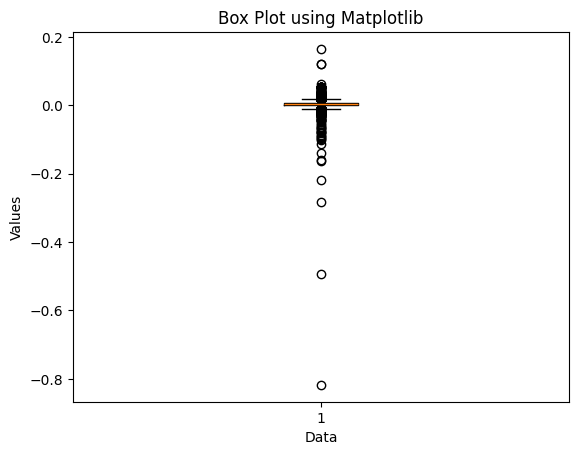

In [68]:
# Create a box plot
plt.boxplot(shareTrend['diff'])
plt.title('Box Plot using Matplotlib')
plt.xlabel('Data')
plt.ylabel('Values')
plt.show()

In [128]:
q1 = np.percentile(shareTrend['diff'], 25) # try 5, 10, 15, 20, 25
q3 = np.percentile(shareTrend['diff'], 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
#upper_bound = q3 + 1.5 * iqr

### 1) Percentile Approach

In [153]:
percentList = [5, 10, 15, 20, 25]
result_ls = []
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result

for i in range(len(percentList)):
    q1 = np.percentile(shareTrend['diff'], i) # try 5, 10, 15, 20, 25
    q3 = np.percentile(shareTrend['diff'], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    # filter data without outliers
    cleaned_data = shareTrend[(shareTrend['diff'] >= lower_bound)]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Measure score
    HHI_Score = []
    # Calculate HHI for each monthly tag share column.
    for j in range(3, cleansed.shape[1], 2):
        HHI_Score.append(square_sum(cleansed.iloc[:, j]))
    result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

    # Model Construction
    hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'HHI' : hhi[:365],
                'T_d': [0]*len(hhi[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'HHI' : hhi[365:],
                'T_d': [1]*len(hhi[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['HHI'])

    # Result Appending
    result_ls.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

In [165]:
result_ls[0] # only works in the first one.

,0,1,2,3,4,5,6
0,,coef,std err,t,P>|t|,[0.025,0.975]
1,Intercept,4.3000,0.073,59.097,0.000,4.157,4.443
2,C(month)[T.2],-0.0276,0.018,-1.510,0.131,-0.063,0.008
3,C(month)[T.3],-0.0524,0.018,-2.941,0.003,-0.087,-0.017
4,C(month)[T.4],-0.0175,0.018,-0.975,0.330,-0.053,0.018
5,C(month)[T.5],-0.0532,0.018,-2.989,0.003,-0.088,-0.018
6,C(month)[T.6],-0.0723,0.018,-4.028,0.000,-0.108,-0.037
7,C(month)[T.7],-0.0578,0.018,-3.248,0.001,-0.093,-0.023
8,C(month)[T.8],-0.0933,0.018,-5.240,0.000,-0.128,-0.058
9,C(month)[T.9],0.0294,0.074,0.400,0.690,-0.115,0.174


### 2) Bottom-K Approach

In [168]:
shareTrend.sort_values('diff', ascending = True).head(10)

,tagName,preGPT,postGPT,diff
17,python,5.378989,4.561351,-0.817638
5,javascript,3.548633,3.055816,-0.492817
72,pandas,0.929865,0.647534,-0.282331
28,arrays,0.578478,0.361360,-0.217118
149,dataframe,0.563057,0.401511,-0.161546
418,sql,0.789951,0.631429,-0.158522
163,list,0.315903,0.176052,-0.139851
21,python3DOTx,0.758491,0.645268,-0.113223
67,html,1.285999,1.183921,-0.102078
38,php,0.838785,0.739441,-0.099344


In [184]:
shareTrend.sort_values('preGPT', ascending = False)

,tagName,preGPT,postGPT,diff
17,python,5.378989,4.561351,-0.817638
5,javascript,3.548633,3.055816,-0.492817
44,reactjs,1.920166,1.832249,-0.087917
63,java,1.592552,1.571811,-0.020741
45,Csharp,1.417443,1.410818,-0.006625
...,...,...,...,...
33764,subobject,0.000000,0.000000,0.000000
33763,rubyffi,0.000000,0.000000,0.000000
33760,slamdata,0.000000,0.000000,0.000000
33759,dynamicfunction,0.000000,0.011746,0.011746


In [170]:
shareTrend.sort_values('diff', ascending = True)[5:]

,tagName,preGPT,postGPT,diff
418,sql,0.789951,0.631429,-0.158522
163,list,0.315903,0.176052,-0.139851
21,python3DOTx,0.758491,0.645268,-0.113223
67,html,1.285999,1.183921,-0.102078
38,php,0.838785,0.739441,-0.099344
...,...,...,...,...
51948,applespeech,0.000000,0.053050,0.053050
29,angular,0.495756,0.557043,0.061287
168,seleniumwebdriver,0.097958,0.218038,0.120081
442,springboot,0.425927,0.546275,0.120348


In [171]:
# cut-off bottom 5, 10, 15, 20
percentList = [5, 10, 15, 20, 25]
result_ls_bottomK = []
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result

for i in range(len(percentList)):
    # filter data without outliers
    cleaned_data = shareTrend.sort_values('diff', ascending = True)[i:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Measure score
    HHI_Score = []
    # Calculate HHI for each monthly tag share column.
    for j in range(3, cleansed.shape[1], 2):
        HHI_Score.append(square_sum(cleansed.iloc[:, j]))
    result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

    # Model Construction
    hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'HHI' : hhi[:365],
                'T_d': [0]*len(hhi[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'HHI' : hhi[365:],
                'T_d': [1]*len(hhi[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['HHI'])

    # Result Appending
    result_ls_bottomK.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

In [182]:
result_ls[0] # only works in the first one.

,0,1,2,3,4,5,6
0,,coef,std err,t,P>|t|,[0.025,0.975]
1,Intercept,4.3000,0.073,59.097,0.000,4.157,4.443
2,C(month)[T.2],-0.0276,0.018,-1.510,0.131,-0.063,0.008
3,C(month)[T.3],-0.0524,0.018,-2.941,0.003,-0.087,-0.017
4,C(month)[T.4],-0.0175,0.018,-0.975,0.330,-0.053,0.018
5,C(month)[T.5],-0.0532,0.018,-2.989,0.003,-0.088,-0.018
6,C(month)[T.6],-0.0723,0.018,-4.028,0.000,-0.108,-0.037
7,C(month)[T.7],-0.0578,0.018,-3.248,0.001,-0.093,-0.023
8,C(month)[T.8],-0.0933,0.018,-5.240,0.000,-0.128,-0.058
9,C(month)[T.9],0.0294,0.074,0.400,0.690,-0.115,0.174


### 3. Percentage Share wise Approach

In [194]:
# cut-off bottom 5, 10, 15, 20
percentList = [5, 10, 15, 20, 25]
result_ls_vr3 = []
# Define square_sum function
def square_sum(numbers):
    result = sum(x**2 for x in numbers if not math.isnan(x))
    return result

for i in range(len(percentList)):
    # filter data without outliers
    cleaned_data = shareTrend.sort_values('preGPT', ascending = False)[i:]
    cleansed = all_keys[all_keys['index'].isin(cleaned_data['tagName'])].reset_index(drop = True)
    # Measure score
    HHI_Score = []
    # Calculate HHI for each monthly tag share column.
    for j in range(3, cleansed.shape[1], 2):
        HHI_Score.append(square_sum(cleansed.iloc[:, j]))
    result_HHI = pd.DataFrame({'year_month':year_month, 'HHI_Score':HHI_Score})

    # Model Construction
    hhi = list(result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().HHI_Score) # fixed datetime
    # Split Data
    control_data = pd.DataFrame({'HHI' : hhi[:365],
                'T_d': [0]*len(hhi[:365]),
                'P_t' : [0]*90 + [1]*275})
    treated_data = pd.DataFrame({'HHI' : hhi[365:],
                'T_d': [1]*len(hhi[365:]),
                'P_t' : [0]*90 + [1]*275})
    df_did = pd.concat([control_data, treated_data], axis = 0).reset_index(drop = True)
    # Add date and month feature
    df_did['date'] = result_HHI[(result_HHI['year_month'] > '2021-08-31') &
            (result_HHI['year_month'] < '2023-09-01')].reset_index().year_month
    df_did['month'] = pd.to_datetime(df_did['date']).dt.month
    # Apply log
    df_did['ln_y'] = np.log(df_did['HHI'])

    # Result Appending
    result_ls_vr3.append(pd.DataFrame(sm.ols('ln_y ~ T_d + P_t + T_d * P_t + C(month)', df_did).fit().summary().tables[1]))

In [193]:
result_ls_vr3[4]

,0,1,2,3,4,5,6
0,,coef,std err,t,P>|t|,[0.025,0.975]
1,Intercept,3.1865,0.045,71.024,0.000,3.098,3.275
2,C(month)[T.2],-0.0111,0.011,-0.984,0.325,-0.033,0.011
3,C(month)[T.3],-0.0131,0.011,-1.192,0.234,-0.035,0.008
4,C(month)[T.4],-0.0192,0.011,-1.734,0.083,-0.041,0.003
5,C(month)[T.5],-0.0039,0.011,-0.351,0.726,-0.025,0.018
6,C(month)[T.6],-0.0258,0.011,-2.328,0.020,-0.047,-0.004
7,C(month)[T.7],-0.0208,0.011,-1.897,0.058,-0.042,0.001
8,C(month)[T.8],-0.0276,0.011,-2.519,0.012,-0.049,-0.006
9,C(month)[T.9],0.0214,0.045,0.473,0.637,-0.068,0.110
